<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Intermediate Pandas

-  Map expressions
- Grouping

### Learning Objectives
*After this lesson, you will be able to:*
- Get comfortable with the **.map()** method on DataFrames for batch manipulations.
- Know what situations **grouping** is useful for
- Explain and use the **`.groupby()`** function in Pandas
- Demonstrate aggregation and plotting methods by groups in Pandas

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format ='retina'

## Warmup / Review / Intro to "map" expressions

Say we have some data on median transactions per month for our users...

In [11]:
transaction_list = [
    "5",
    "12",
    "0",
    "9",
    "45",
    "6",
    "39",
    "84",
    "40",
    "19",
    "23",
    "87",
    "26",
    "1"   
]

In [21]:
type(transaction_list[0])

str

Let's take the mean of these data.

In [26]:
np.mean(transaction_list)

28.285714285714285

So that didn't work.

### <font color=blue>(Independent)</font> Activity: Process the `transaction_data` so its mean can be properly taken.

In [29]:
# Complete activity below

transaction_list_int = []
for i in transaction_list:
    transaction_list_int.append(int(i))

np.mean(transaction_list_int)
np.median(transaction_list_int)

21.0

What if our data was in a `DataFrame` or a `Series` instead of a `list`. It is possible to loop through pandas objects, just like we did with the list, but that isn't a best practice. Instead pandas offers the `.map()` method, dedicated functionality to perform iterative-like transformations.

**Pandas type transformation**:

In [30]:
#Create DataFrame
transaction_df = pd.DataFrame(transaction_list, columns = ["median_transaction_count"])
transaction_df.head()

,median_transaction_count
0,5
1,12
2,0
3,9
4,45


In [42]:
transaction_df.info()

transaction_df.mean()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 1 columns):
median_transaction_count    14 non-null int64
dtypes: int64(1)
memory usage: 184.0 bytes


median_transaction_count    28.285714
dtype: float64

(codealong) Convert the transaction_count column into Ints

In [35]:
# To Do

transaction_df["median_transaction_count"] = transaction_df["median_transaction_count"].map(int)

**Warning:** `.map()` is a `Series` method, it will not work on `DataFrames`. Instead you need either `.applymap()` or `.apply()`, which will come up later on.

#### How do we handle converting types if we have messier data?

In [37]:
transaction_messy_list = [
    "5",
    "12",
    "0",
    "9",
    "?",
    "6",
    "missing",
    "84",
    "40",
    "?",
    "23",
    "87",
    "26",
    "one",
    "7"
]

#Create df
transaction_messy_df = pd.DataFrame(transaction_messy_list, columns = ["median_transaction_count"])

In [40]:
transaction_messy_df["median_transaction_count"].map(int)

ValueError: invalid literal for int() with base 10: '?'

We can "map" custom functions that we right ourselves. This gives us ALOT of flexibility.

### <font color=blue>(Independent)</font> Activity: Write a function to process a single transaction value

In [48]:
def clean_transaction_value2(number_string):
    """
    Convert strings of numeric values to Int, otherwise return np.nan
    """
    #Your work here
    transaction_clean_list = []
    for i in number_string:
        try:
            transaction_clean_list.append(int(i))
        except:
            transaction_clean_list.append("Nan")
    print transaction_clean_list
clean_transaction_value2(transaction_messy_list)
            

[5, 12, 0, 9, 'Nan', 6, 'Nan', 84, 40, 'Nan', 23, 87, 26, 'Nan', 7]


In [56]:
def clean_transaction_value(number_string):
    """
    Convert strings of numeric values to Int, otherwise return np.nan
    """
    #Your work here
    
    if number_string.isdigit():
        return int(number_string)
    else:
        return np.nan

Now lets use this function to clean our `transaction_messy_df`.

In [59]:
# (codealong) to do
transaction_messy_df["median_transaction_count"] = transaction_messy_df["median_transaction_count"].map(clean_transaction_value)


AttributeError: 'float' object has no attribute 'isdigit'



## Introduction to Pandas Grouping

---

### Lesson Guide

- [Overview of multi-dimensional data analysis](#overview)
- [Examples of when to group data](#grouping_examples)
- [Load the Titanic dataset](#load_titanic)
- [Introduction to pandas `.groupby()`](#groupby)
- [Grouping by multiple variables](#groupby_multiple)
- [Applying basic functions to groups](#basic_functions)
- [Removing the hierarchical index](#removing_hierarchical)
- [Applying custom functions with apply](#custom_functions)
- [Plotting basic histograms with groups](#basic_plotting)
- [Grouped histograms](#grouped_hists)
- [Independent practice](#independent_practice)



> ## The goal of grouping and aggregation is to describe segments of your data based on unique values of a feature


<a id='grouping_examples'></a>

### Analyzing data by group: some specific examples

---

 - Sum of crimes by time of day in SF (morning, afternoon, night)
 - Count number of people with the same last name
 - Median number of multi-unit buildings in a region
 - Popularity of movie genres by region
 - Segmenting customers based on age, buying habbits, interests, behavior
 - Using the "GROUP BY" clause in a database query using SQL

##  Example

---

### Count of crimes by day

index| day_of_week| time_of_day | suspect_apprehended 
- |------|------|------ 
0 |   tuesday | night| 1
1 |   friday | afternoon| 1
2 |   thursday  | afternoon| 0
3 |   friday  | night| 1
4 |   friday | night| 0
5 |   tuesday | night| 0
6 |   thursday | morning| 1
7 |   friday | night| 1

> *Which day of the week has the most crime?*

In SQL you use a `GROUP BY` statement like:

```SQL
SELECT day_of_week,
       COUNT(*)
FROM crimes;
```

Pandas has its own grouping and aggregation syntax:
```python
crime_df.groupby("day_of_week").size()
```

Either of these operations would produce table something like:

index| day_of_week| count
- |------|------|------ 
0 |   tuesday | 2
1 |   thursday | 2
2 |   friday  | 4

You can see that the resulting dataframe has **unique** values for `day_of_week` because that's the column we grouped by. The `.size()` aggregator method returns how many rows are in each group.


### Grouping by multiple columns

> *Which `day_of_week` / `time_of_day` has the highest apprehension rate?*

Now we want to aggegrate on all unique combinations of both of those columns.

In SQL:

```SQL
SELECT day_of_week,
       time_of_day,
       AVG(suspect_apprehended) AS apprehension_rate
FROM crimes
GROUP BY day_of_week,
         time_of_day;
```

In Pandas:

```python
crime_df.groupby(["day_of_week", "time_of_day"])["apprehended"].mean()
```

We get:

index| day_of_week| time_of_day | apprehension_rate
- |------|------|------ 
0 |   tuesday | night | 0.5 
1 |   thursday | morning | 1
2 |   thursday | afternoon | 0
3 |   friday  | afternoon | 1
4 |   friday  | night | 0.66


#### Subset aggregation:

This chart stratifies a single variable "Industry", **counting** job openings within category.

![](http://www.rasmussen.edu/images/blogs/1360270834-402_Graphs_JobOpeningsByIndustry.jpg)

#### Hierarchical aggregation

This chart aggregates first by a top level group, "industry", and then a secondary group "date" within each industry.

![](http://junkcharts.typepad.com/.a/6a00d8341e992c53ef0192acc65090970d-pi)

##  Anatomy of the `groupby` statement

---

![](https://i.imgur.com/ZvFed5Q.png)

<a id='load_titanic'></a>

### Exploring the Titanic dataset with grouping

---

To explore the power of grouping with pandas we will be using [the famous Titanic dataset that can be downloaded from Kaggle](https://www.kaggle.com/c/titanic). From the competition decription:

>The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

>One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

Though we will not be doing any modeling of survival rates in this lesson, there are interesting patterns to be found just by exploring descriptive statistics in cross-sections of the data.

**Load the data into pandas.**

In [61]:
path_to_file = './datasets/titanic_clean.csv'

titanic = pd.read_csv(path_to_file)

titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


The data contains a variety of information about passengers involved in the sinking of the Titanic.

**Describe the data in the columns with summary statistics.**

In [66]:
#titanic.info()
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,448.589888,0.404494,2.240169,29.642093,0.514045,0.432584,34.567251
std,258.683191,0.491139,0.836854,14.492933,0.930692,0.854181,52.938648
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.750000,0.000000,1.000000,20.000000,0.000000,0.000000,8.050000
50%,445.000000,0.000000,2.000000,28.000000,0.000000,0.000000,15.645850
75%,677.250000,1.000000,3.000000,38.000000,1.000000,1.000000,33.000000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


<a id='groupby'></a>

### Intro to `.groupby()` in pandas

---

The built-in `.groupby()` functions for dataframes is one of the most useful tools in pandas. As the name implies, `.groupby` will group your dataset by one or more user-specified column names.

**Using `.groupby`, create a grouped dataframe where the titanic dataset is grouped by "Pclass".**

In [75]:
grouped = titanic.groupby("Pclass")

**Print out the type of the grouped dataframe.**

In [76]:
for group in grouped:
    print "group_type", group[0]
    print "head", group[1].head()
    print "--------------------"

group_type 1
head     PassengerId  Survived  Pclass  \
1             2         1       1   
3             4         1       1   
5             7         0       1   
10           12         1       1   
20           24         1       1   

                                                 Name     Sex   Age  SibSp  \
1   Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
3        Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
5                             McCarthy, Mr. Timothy J    male  54.0      0   
10                           Bonnell, Miss. Elizabeth  female  58.0      0   
20                       Sloper, Mr. William Thompson    male  28.0      0   

    Parch     Fare Embarked  
1       0  71.2833        C  
3       0  53.1000        S  
5       0  51.8625        S  
10      0  26.5500        S  
20      0  35.5000        S  
--------------------
group_type 2
head     PassengerId  Survived  Pclass                                 Name 

Instead of a `DataFrame` object we now have a `DataFrameGroupBy` object. This operates somewhat differently than the DataFrame we are used to, as we shall see.

**Try pulling out the first group from the grouped dataframe with index 0.**

3

Grouped dataframes do not work the same as python lists. You can't pull out the different groups with indexers. Despite this, grouped dataframe objects **are** iterable! You can step through them using a for-loop, for example.

In our grouped dataframe, each element will be a tuple containing the Pclass group as its first element, and the subset of the original titanic dataframe for that Pclass as it's second element.

**Write a for-loop to iterate through the grouped dataframe, printing out the PClass and the header of the subset each time.**

In [99]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


<a id='groupby_multiple'></a>

### Grouping by multiple fields

---

Grouping by more than one column is simple. The `.groupby()` function can take a list of column names to group by. When you group by more than one column, each subset of the data will correspond to one of the distinct combinations of the grouping columns.

**Create a grouped dataframe by grouping the titanic data by "Pclass" and "Survived".**

In [ ]:
titanic.groupby(["Pclass","Survived"])

**Print out the length of this grouped dataframe.**

It is the same length as unique combinations of Pclass and Survied: 3 Pclasses by 2 Survival values.

In [78]:
len(titanic.groupby(["Pclass","Survived"]))

6

<a id='basic_functions'></a>

### Applying basic functions to groups

---

Pandas makes it easy to apply basic statistical functions to the grouped data with built-in functions. For example, if you have a grouped dataframe `grouped`:

```python
print group.mean()
print group.median()
print group.count()
print group.max()
```

We can get the mean, median, count, and max of the columns by group. 

**Try out these built in functions on the grouped data you made above.**

In [79]:
grouped.mean()

,PassengerId,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,464.157609,0.652174,38.105543,0.456522,0.413043,88.048121
2,447.156069,0.479769,29.877630,0.427746,0.404624,21.471556
3,441.219718,0.239437,25.140620,0.585915,0.456338,13.229435


You can also operate on single columns or subsets of columns across grouped dataframes using the indexing syntax for standard dataframes.

**Find the percent of passengers who survived by where they embarked.**

In [85]:
titanic.groupby(["Embarked","Pclass"])["Survived"].mean()

Embarked  Pclass
C         1         0.716216
          2         0.533333
          3         0.439024
Q         1         0.500000
          2         0.500000
          3         0.250000
S         1         0.611111
          2         0.474359
          3         0.210345
Name: Survived, dtype: float64

**Find the average fare and age grouped by the location embarked and the class.**

In [86]:
embarked_class_group = titanic.groupby(["Embarked","Pclass"])[["Fare","Age"]].mean()

In [87]:
embarked_class_group.reset_index()

,Embarked,Pclass,Fare,Age
0,C,1,108.246399,38.027027
1,C,2,26.811947,22.766667
2,C,3,11.369927,20.741951
3,Q,1,90.000000,38.500000
4,Q,2,12.350000,43.500000
5,Q,3,12.780904,25.937500
6,S,1,74.172415,38.152037
7,S,2,21.075000,30.386731
8,S,3,13.529451,25.696552


<a id='removing_hierarchical'></a>

### Removing the hierarchical index

---

By default pandas will give you back your groups in a hierarchical index format. If this is not preferable to you, you can use the `.reset_index()` function to take your row labels and convert them into columns.

**Remove the hierarchical index for the average fare and age dataset you just created, converting Embarked and Pclass to columns.**

In [90]:
embarked_class_group = embarked_class_group.reset_index()

<a id='custom_functions'></a>

### Applying your own functions to groups with `.apply()`

---

While pandas does contain a variety of useful built-in summary functions, it is common that you will need to apply a custom function to the data in your groups. 

The `.apply()` function takes a function as an argument and applies it to the subsets of data in your dataframe groups.

**See what happens when you replace the built-in `.mean()` function with a `.apply(np.mean)` for the question above.**

In [91]:
titanic.groupby(["Embarked","Pclass"])[["Fare","Age"]].apply(np.mean)

Fare        Age
Embarked Pclass                       
C        1       108.246399  38.027027
         2        26.811947  22.766667
         3        11.369927  20.741951
Q        1        90.000000  38.500000
         2        12.350000  43.500000
         3        12.780904  25.937500
S        1        74.172415  38.152037
         2        21.075000  30.386731
         3        13.529451  25.696552

Say we wanted to have the mean of fare and age per embarked and pclass, but we wanted the numbers to be rounded. One way to do this would be to round the columns after we had applied the mean function as we did above. 

Another way would be to write a custom function to pass into apply. *The function passed to `.apply()` will be run on all of the subsets of data.*

**<font color=blue>(Independent)</font> Write a function that will take the mean of a pandas Series and round the value.**

In [94]:
def mean_rounded(group):
    mean = group.mean()
    return mean.round(2)

**Apply your custom function to the grouped data.**

In [96]:
titanic.groupby(["Embarked","Pclass"])[["Fare","Age"]].apply(mean_rounded)

Fare     Age
Embarked Pclass                 
C        1       108.246  38.027
         2        26.812  22.767
         3        11.370  20.742
Q        1        90.000  38.500
         2        12.350  43.500
         3        12.781  25.938
S        1        74.172  38.152
         2        21.075  30.387
         3        13.529  25.697

<a id='basic_plotting'></a>

### Basic pandas histograms with grouped data

---

We can leverage the power of pandas even more by mixing its plotting capabilities with its grouping capabilities.

**First find the number of passengers per PClass by using `.groupby` and `.size`.**

In [97]:
titanic.groupby("Pclass").size()

Pclass
1    184
2    173
3    355
dtype: int64

Here we have a series object with the counts of passengers per class group. It is simple to get a histogram of these counts by appending `.plot(kind="bar", color="g", width=0.85)`.

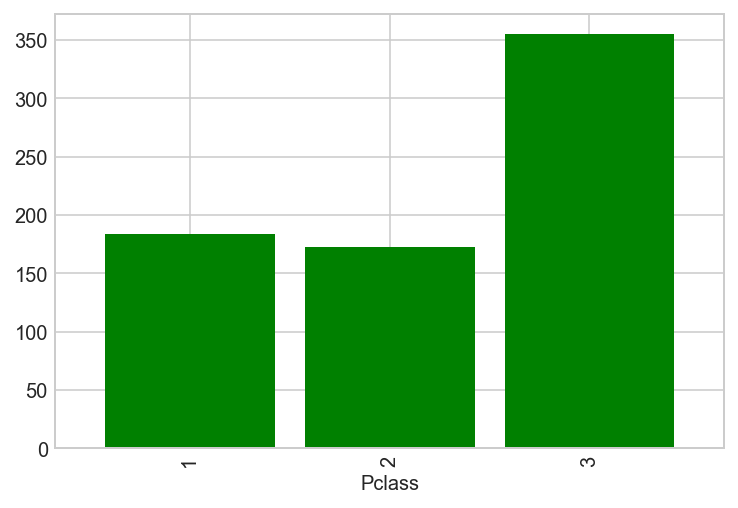

In [98]:
titanic.groupby("Pclass").size().plot(kind="bar", color="g", width=0.85)

**<font color=blue>(Independent)</font> Plot the average fare per sex and class as a barplot.**

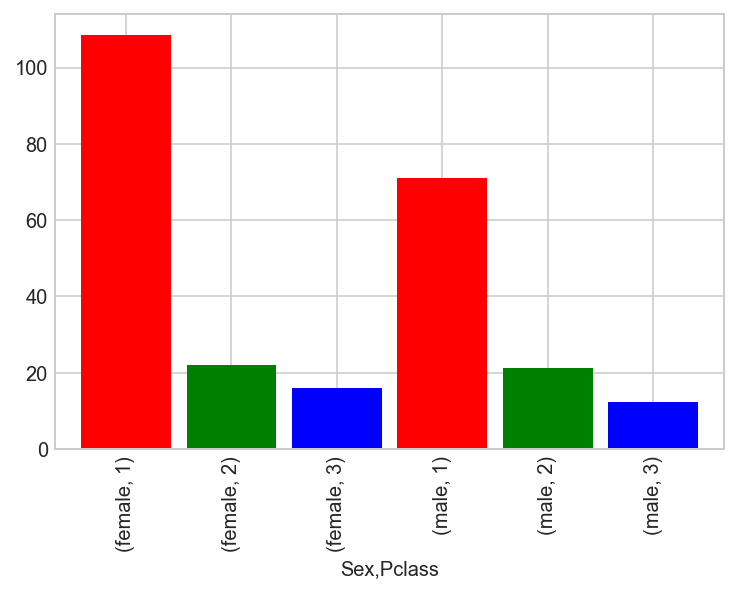

In [113]:
titanic.head()

titanic.groupby(["Sex","Pclass"])["Fare"].mean().plot(kind="bar", color="rgb", width=0.85)


<a id='grouped_hists'></a>

### Grouped histograms with pandas

---

In the chart we just made, each bar represents a distinct combination of our groups in the `.groupby`. This is fine, but it would be a more visually appealing and informative chart if we had one of the groups as different colors and could make a grouped bar chart.

**Calculate the mean of Fare by Pclass and Sex using `groupby`, assign it to a variable, and print it out.**

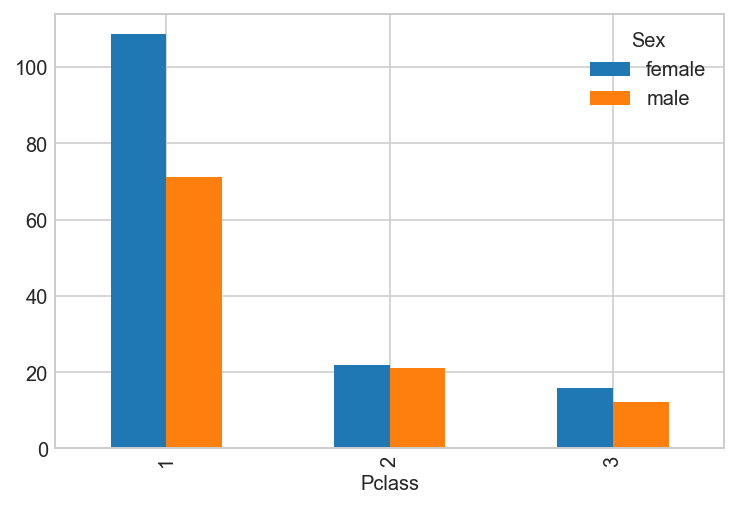

In [117]:
titanic.groupby(["Pclass", "Sex"])["Fare"].mean().unstack().plot(kind = "bar")

There is another built-in function for pandas objects called `.unstack()`. When we have a hierarchical index like we do above with Pclass as the broader category and Sex as the sub-category, the `.unstack()` command will attempt to move the subcategory from an index to column representation.

This is a way to move from a "long" to "wide" column format.

**Use the `.unstack()` function on your mean fare variable.**

In [120]:
titanic.groupby(["Pclass", "Sex"])["Fare"].mean().unstack().T

Pclass,1,2,3
Sex,,,
female,108.619680,21.951070,15.875369
male,71.142781,21.113131,12.162695


**Now use the plot function on the unstacked data to create a bar chart.**

If you add the keyword variable `stacked=True` it will instead stack the bars within the broader Pclass category.